# Twenty Newsgroups with Pyspark

#### Author: Greg Strabel

This notebook demonstrates the use of pyspark (running in standalone) in the Twenty Newsgroups classification problem

In [1]:
## Import everything we'll need
import findspark
findspark.init()
from pyspark import SparkContext, sql
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import ArrayType, IntegerType, DoubleType, StringType, StructType, StructField
from pyspark.ml.feature import HashingTF, IDF, \
    Tokenizer, StopWordsRemover, CountVectorizer, \
    CountVectorizerModel, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import re
import string
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Create a Spark Session, Context and SQL Context
spark = sql.SparkSession.builder.appName("NewsGroups").getOrCreate()
sc = spark.sparkContext
sqlContext = sql.SQLContext(sparkContext=sc, sparkSession=spark)

In [3]:
# Fetch Twenty Newsgroups dataset and remove headers, footers and quotes
newsgroups_train = fetch_20newsgroups(subset='train',
                remove = ('headers','footers','quotes'))
newsgroups_train_features, newsgroups_train_targets = shuffle(
    newsgroups_train.data, newsgroups_train.target, random_state = 0)

newsgroups_test = fetch_20newsgroups(subset='test',
                remove = ('headers','footers','quotes'))

newsgroups_test_features, newsgroups_test_targets = shuffle(
    newsgroups_test.data, newsgroups_test.target, random_state = 0)

## Topic names:
topics = newsgroups_train.target_names

In [4]:
## Dump the data to json
train = [json.dumps(
    {"target":newsgroups_train.target_names[int(newsgroups_train_targets[i])],
     "features":newsgroups_train_features[i]}
        ) for i in range(len(newsgroups_train_targets))]

test = [json.dumps(
    {"target": newsgroups_test.target_names[int(newsgroups_test_targets[i])],
     "features":newsgroups_test_features[i]}
        ) for i in range(len(newsgroups_test_targets))]

In [5]:
### Take a look at the first training observation
train[0]

'{"target": "comp.graphics", "features": "[Most info regarding dangers of reading from Floppy disks omitted]\\n\\nIn all fairness, how many people do you know personally who read images\\nfrom Floppy drives?  I haven\'t tried it with JPEGs, but I do realize how\\nagonizingly slow it is with GIF files.  "}'

In [6]:
## Get the data into Spark
train_spark = sc.parallelize(train)
train_spark_df = sqlContext.read.json(train_spark)

test_spark = sc.parallelize(test)
test_spark_df = sqlContext.read.json(test_spark)

In [7]:
## Take a look at the data - converting back to Pandas DataFrame
train_spark_df.limit(5).toPandas()

,features,target
0,[Most info regarding dangers of reading from F...,comp.graphics
1,Attention hardware hackers and bargain seekers...,sci.electronics
2,A friend's daughter has been diagnosed with an...,sci.med
3,WHile we are on the subject of the shuttle sof...,sci.space
4,\n\nThat is great to hear I just may have to t...,rec.sport.baseball


In [8]:
### Cleanup features by removing non-alphabetic characters
train_spark_df = train_spark_df.\
    withColumn('features_clean',
               F.regexp_replace(col("features"), '[^A-Za-z\s(\'a-z)]|\(|\)', ' '))
    
test_spark_df = test_spark_df.\
    withColumn('features_clean',
               F.regexp_replace(col("features"), '[^A-Za-z\s(\'a-z)]|\(|\)', ' '))
## Note: (\'\a) is a cheap way to avoid splitting contractions - should think more about this

In [9]:
## Take a look at the clean features...not that clean
train_spark_df.select('features','features_clean').limit(5).toPandas()

,features,features_clean
0,[Most info regarding dangers of reading from F...,Most info regarding dangers of reading from F...
1,Attention hardware hackers and bargain seekers...,Attention hardware hackers and bargain seekers...
2,A friend's daughter has been diagnosed with an...,A friend's daughter has been diagnosed with an...
3,WHile we are on the subject of the shuttle sof...,WHile we are on the subject of the shuttle sof...
4,\n\nThat is great to hear I just may have to t...,\n\nThat is great to hear I just may have to t...


In [10]:
### Tokenize words
tokenizer = Tokenizer(inputCol="features_clean", outputCol="words")
train_spark_df = tokenizer.transform(train_spark_df)
test_spark_df = tokenizer.transform(test_spark_df)

In [11]:
## Note that the column 'words' is an array of strings
train_spark_df.printSchema()

root
 |-- features: string (nullable = true)
 |-- target: string (nullable = true)
 |-- features_clean: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [12]:
### Remove Stopwords
remover = StopWordsRemover(inputCol="words", outputCol="words_xStopwords")
train_spark_df = remover.transform(train_spark_df)
test_spark_df = remover.transform(test_spark_df)

In [13]:
## Stem the remaining words
stemmer = SnowballStemmer(language="english") #PorterStemmer()
stemmer_udf = F.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
train_spark_df = train_spark_df.withColumn("words_xStopwords_stemmed",
                                           stemmer_udf("words_xStopwords"))
test_spark_df = test_spark_df.withColumn("words_xStopwords_stemmed",
                                           stemmer_udf("words_xStopwords"))

In [14]:
## Get rid of any stemmed strings that are 0 or 1 character

train_spark_df = train_spark_df.withColumn("words_xStopwords_stemmed_filtered",
    F.udf(lambda x: [i for i in x if len(i) > 1],
    ArrayType(StringType()))(col("words_xStopwords_stemmed")))

test_spark_df = test_spark_df.withColumn("words_xStopwords_stemmed_filtered",
    F.udf(lambda x: [i for i in x if len(i) > 1],
    ArrayType(StringType()))(col("words_xStopwords_stemmed")))

In [15]:
## Get rid of any strings that are 0 or 1 characters

train_spark_df = train_spark_df.withColumn("words_filtered",
    F.udf(lambda x: [i for i in x if len(i) > 1],
    ArrayType(StringType()))(col("words")))

test_spark_df = test_spark_df.withColumn("words_filtered",
    F.udf(lambda x: [i for i in x if len(i) > 1],
    ArrayType(StringType()))(col("words")))

In [16]:
## Take a look at the data again
train_spark_df.select(
    'features',
    'words_filtered',
    'words_xStopwords_stemmed_filtered'
).limit(5).toPandas()

,features,words_filtered,words_xStopwords_stemmed_filtered
0,[Most info regarding dangers of reading from F...,"[most, info, regarding, dangers, of, reading, ...","[info, regard, danger, read, floppi, disk, omi..."
1,Attention hardware hackers and bargain seekers...,"[attention, hardware, hackers, and, bargain, s...","[attent, hardwar, hacker, bargain, seeker, bou..."
2,A friend's daughter has been diagnosed with an...,"[friend's, daughter, has, been, diagnosed, wit...","[friend, daughter, diagnos, eye, diseas, call,..."
3,WHile we are on the subject of the shuttle sof...,"[while, we, are, on, the, subject, of, the, sh...","[subject, shuttl, softwar, ever, happen, hypot..."
4,\n\nThat is great to hear I just may have to t...,"[that, is, great, to, hear, just, may, have, t...","[great, hear, may, take, raod, trip, milwake, ..."


In [17]:
## Now we have several columns that are arrays of strings
train_spark_df.printSchema()

root
 |-- features: string (nullable = true)
 |-- target: string (nullable = true)
 |-- features_clean: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_xStopwords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_xStopwords_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_xStopwords_stemmed_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [18]:
## Get the 500 most frequent stemmed words
count_vectorizer = CountVectorizer(minTF=1.0,
                                   minDF=2.0,
                                   vocabSize=500,
                                   binary = True,
                                   inputCol='words_xStopwords_stemmed_filtered',
                                   outputCol='word_tags')

count_vectorizer_transformer = count_vectorizer.fit(train_spark_df)

In [19]:
## Print the 500 most frequent stemmed words
", ".join(sorted(count_vectorizer_transformer.vocabulary))

'abl, accept, access, act, action, actual, ad, addit, address, advanc, ago, agre, allow, almost, alreadi, also, although, alway, american, anonym, anoth, answer, anyon, anyth, anyway, appear, applic, appreci, april, area, argument, armenian, around, articl, ask, assum, attack, author, avail, away, ax, back, bad, base, basic, becom, believ, best, better, bhj, bibl, big, bill, bit, board, bodi, book, box, build, buy, ca, call, came, car, card, care, carri, case, caus, center, certain, chang, check, children, chip, christian, church, citi, claim, clear, close, code, color, com, come, command, comment, common, compani, complet, comput, connect, consid, contact, contain, continu, control, convert, copi, correct, cost, countri, cours, cover, creat, cs, current, cx, data, day, db, deal, death, defens, defin, design, detail, develop, devic, di, die, differ, direct, discuss, disk, display, document, done, dos, drive, driver, edu, effect, ei, either, els, email, encrypt, end, engin, enough, entr

In [20]:
## Index the target column for model fitting
labelIndexer = StringIndexer(inputCol="target", outputCol="label").fit(train_spark_df)
train_spark_df = labelIndexer.transform(train_spark_df)
test_spark_df = labelIndexer.transform(test_spark_df)

In [21]:
## Create pipline of a count vectorizer and logistic regression
## along with grid for hyperparameter search

count_vectorizer = CountVectorizer(minTF=1.0,
                                   minDF=2.0,
                                   binary = True,
                                   inputCol='words_xStopwords_stemmed_filtered',
                                   outputCol='word_tags')

lr = LogisticRegression(featuresCol='word_tags',
                        labelCol='label')

pipeline = Pipeline(stages=[count_vectorizer,lr])

paramGrid = ParamGridBuilder()\
    .addGrid(count_vectorizer.vocabSize, [100,500])\
    .addGrid(lr.regParam, [0.01, 0.001])\
    .build()

In [22]:
## Initialize the cross validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_spark_df)

In [23]:
## Get best model
bestModel = cvModel.bestModel

In [24]:
## Predict on test data
prediction = cvModel.transform(test_spark_df)

In [25]:
## Convert predicted indices back to string labels
predictedLabel = IndexToString(inputCol='prediction',
                               outputCol='predicted',
                               labels=labelIndexer.labels)

In [26]:
## Get predicted labels
prediction = predictedLabel.transform(prediction)

In [27]:
## Take a look at actuals and predicteds
prediction.select(
    'target',
    'label',
    'predicted',
    'prediction').limit(5).toPandas()

,target,label,predicted,prediction
0,soc.religion.christian,1.0,soc.religion.christian,1.0
1,sci.crypt,4.0,comp.graphics,13.0
2,sci.med,5.0,misc.forsale,12.0
3,sci.crypt,4.0,sci.crypt,4.0
4,rec.autos,6.0,sci.electronics,10.0


In [28]:
# Get (prediction, label) tuple in rdd
predictionsAndLabels = prediction.rdd.map(lambda lp: (lp.prediction, lp.label))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionsAndLabels)

In [29]:
# Overall statistics
precision = round(metrics.precision(),3)
recall = round(metrics.recall(),3)
f1Score = round(metrics.fMeasure(),3)
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
    
# Statistics by class
# for label in sorted(topics):
#     print("Class %s precision = %s" % (label, metrics.precision(labelIndexer.labels.index(label))))
#     print("Class %s recall = %s" % (label, metrics.recall(labelIndexer.labels.index(label))))
#     print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(
#                 label = float(labelIndexer.labels.index(label)),
#                 beta=1.0)))

# Weighted stats
print("Weighted recall = %s" % round(metrics.weightedRecall,3))
print("Weighted precision = %s" % round(metrics.weightedPrecision,3))
print("Weighted F(1) Score = %s" % round(metrics.weightedFMeasure(),3))
print("Weighted F(0.5) Score = %s" % round(metrics.weightedFMeasure(beta=0.5),3))
print("Weighted false positive rate = %s" % round(metrics.weightedFalsePositiveRate,3))

Summary Stats
Precision = 0.452
Recall = 0.452
F1 Score = 0.452
Weighted recall = 0.452
Weighted precision = 0.467
Weighted F(1) Score = 0.455
Weighted F(0.5) Score = 0.461
Weighted false positive rate = 0.029


In [30]:
## Normalized Confusion Matrix
preConfusionMatrix = (prediction
                      .groupBy(['target','predicted'])
                      .count()
                      .toPandas()
                     )

In [31]:
## Take a look at the normalized confusion matrix
preConfusionMatrix.head(5)

,target,predicted,count
0,comp.os.ms-windows.misc,alt.atheism,3
1,sci.space,sci.electronics,32
2,talk.politics.mideast,talk.politics.guns,17
3,comp.sys.ibm.pc.hardware,comp.graphics,23
4,rec.sport.baseball,talk.politics.mideast,3


In [32]:
## Calculate generalized recall and rrecision
recallMatrix = preConfusionMatrix.copy()
precisionMatrix = preConfusionMatrix.copy()
recallMatrix['fraction'] = (
    preConfusionMatrix
    .groupby('target')['count']
    .transform(lambda x: x / x.sum())
)

precisionMatrix['fraction'] = (
    preConfusionMatrix
    .groupby('predicted')['count']
    .transform(lambda x: x / x.sum())
)

In [33]:
## Pivot the recall and precision tables
recallMatrix = (
    recallMatrix
    .pivot_table(index = 'predicted',
                 columns='target',
                 values='fraction',
                 fill_value=0)
)

precisionMatrix = (
    precisionMatrix
    .pivot_table(index = 'target',
                 columns='predicted',
                 values='fraction',
                 fill_value=0)
)

In [34]:
## Take a look - so we understand what we've created
recallMatrix.iloc[0:5,0:5]

target,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware
predicted,,,,,
alt.atheism,0.285266,0.012853,0.007614,0.002551,0.005195
comp.graphics,0.000000,0.526992,0.081218,0.058673,0.028571
comp.os.ms-windows.misc,0.000000,0.061697,0.459391,0.104592,0.023377
comp.sys.ibm.pc.hardware,0.000000,0.030848,0.086294,0.390306,0.132468
comp.sys.mac.hardware,0.006270,0.046272,0.048223,0.153061,0.436364


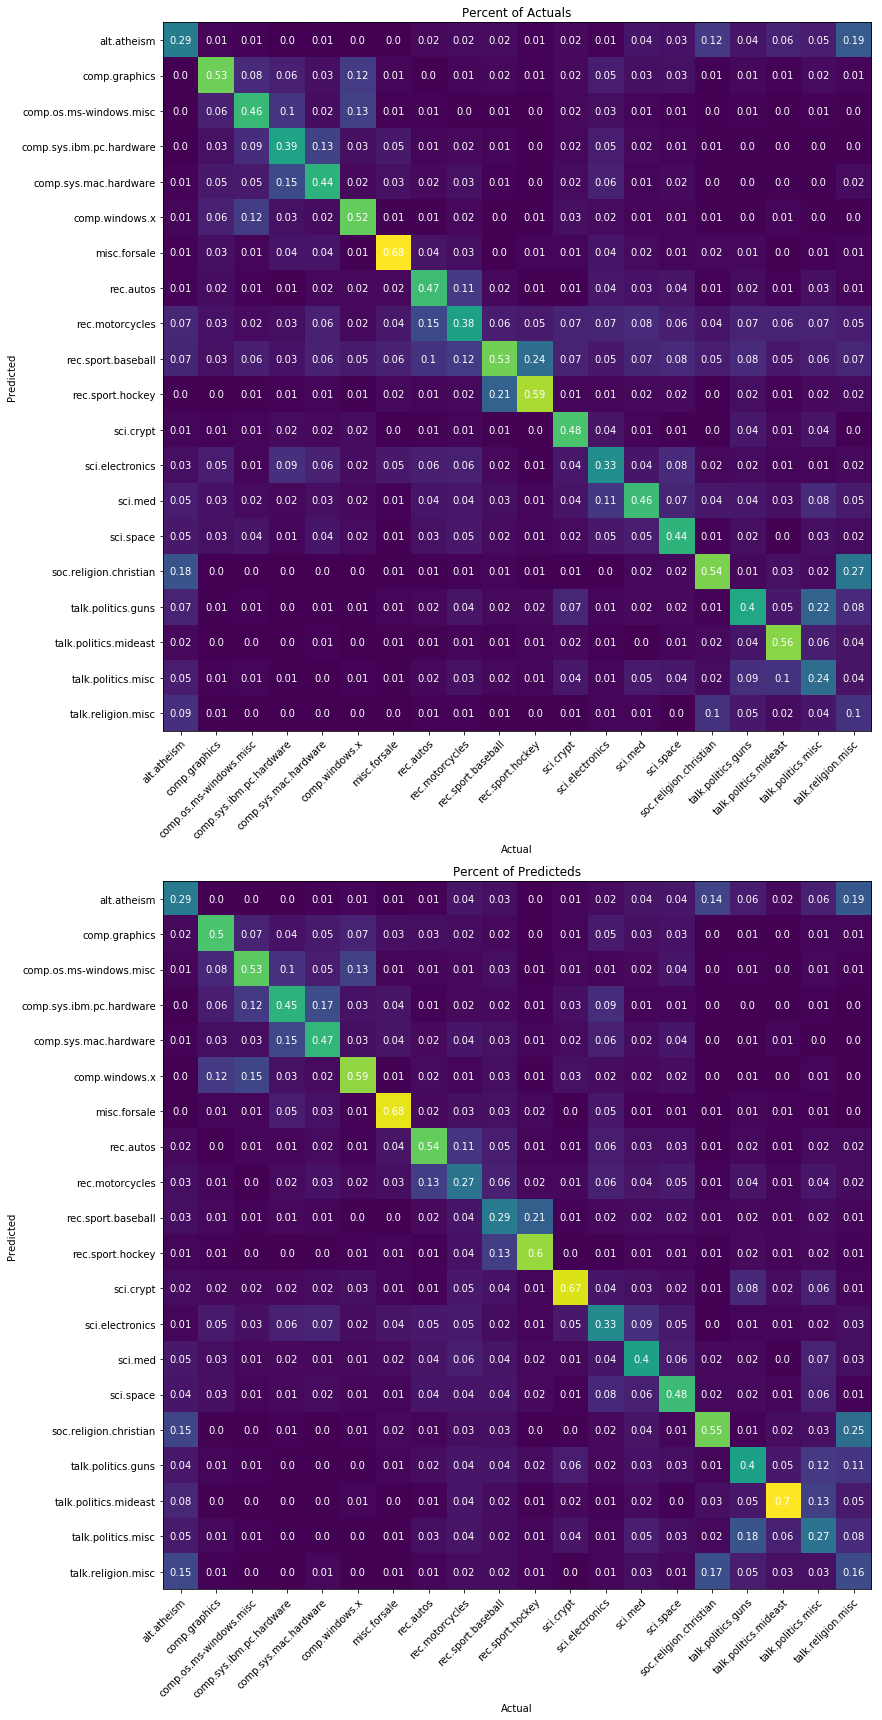

In [35]:
## Plot generalized recall and precision matrices
fig, ax = plt.subplots(ncols=1,nrows=2,figsize = (12,24))
im0 = ax[0].imshow(recallMatrix.values)
im1 = ax[1].imshow(precisionMatrix.values)

for i in [0,1]:
    # We want to show all ticks...
    ax[i].set_xticks(np.arange(len(topics)))
    ax[i].set_yticks(np.arange(len(topics)))
    # ... and label them with the respective list entries
    ax[i].set_xticklabels(topics)
    ax[i].set_yticklabels(topics)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    ax[i].set_xlabel('Actual')
    ax[i].set_ylabel('Predicted')

# Loop over data dimensions and create text annotations.
for i in range(len(topics)):
    for j in range(len(topics)):
        text = ax[0].text(j, i, round(recallMatrix.values[i, j],2),
                       ha="center", va="center", color="w")
        text = ax[1].text(j, i, round(precisionMatrix.values[i, j],2),
                       ha="center", va="center", color="w")

ax[0].set_title("Percent of Actuals")
ax[1].set_title("Percent of Predicteds")
fig.tight_layout()
plt.show()

In [36]:
## Create arrays of one-hot encoded labels and probabilities
## in prep for calculating micro-averaged ROC Curve
microAverageROC = (
    prediction.select('label','probability').
    withColumn('label_encoded',
               F.udf(lambda x: [float(i == int(x)) for i in range(20)],
                   ArrayType(DoubleType()))
               (col('label'))).
    withColumn('prob',
               F.udf(lambda x: x.toArray().tolist(), ArrayType(DoubleType()))
               (col('probability')))
)

In [37]:
## Check out what we've created
microAverageROC.limit(5).show()

+-----+--------------------+--------------------+--------------------+
|label|         probability|       label_encoded|                prob|
+-----+--------------------+--------------------+--------------------+
|  1.0|[5.35469346280713...|[0.0, 1.0, 0.0, 0...|[5.35469346280713...|
|  4.0|[0.00751691501662...|[0.0, 0.0, 0.0, 0...|[0.00751691501662...|
|  5.0|[0.05182429358373...|[0.0, 0.0, 0.0, 0...|[0.05182429358373...|
|  4.0|[4.55637918282476...|[0.0, 0.0, 0.0, 0...|[4.55637918282476...|
|  6.0|[0.06773264511840...|[0.0, 0.0, 0.0, 0...|[0.06773264511840...|
+-----+--------------------+--------------------+--------------------+



In [38]:
## Note that both label_encoded and prob are arrays of doubles
microAverageROC.printSchema()

root
 |-- label: double (nullable = false)
 |-- probability: vector (nullable = true)
 |-- label_encoded: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- prob: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [39]:
## Zip together label_encoded and prob arrays and then explode them

## Zip udf
zip_ = F.udf(
  lambda x, y: list(zip(x, y)),
  ArrayType(StructType([
      # Adjust types to reflect data types
      StructField("first", DoubleType()),
      StructField("second", DoubleType())
  ]))
)

## Zip together label_encoded and prob arrays and then explode them
microAverageROC = (microAverageROC.select('label_encoded','prob')
    .withColumn("tmp", zip_("label_encoded", "prob"))
    # UDF output cannot be directly passed to explode
    .withColumn("tmp", F.explode("tmp"))
    .select(col("tmp.first").alias('label_encoded'),
            col("tmp.second").alias("probability")))

In [40]:
## Take a look at the data frame to understand what exploding did
microAverageROC.limit(5).toPandas()

,label_encoded,probability
0,0.0,0.000005
1,1.0,0.906183
2,0.0,0.000304
3,0.0,0.000007
4,0.0,0.000653


In [41]:
## Round probabilities to 3 digits,
## group by them and
## calculate total records and
## sum of label_encoded
microAverageROC = (
    microAverageROC
    .withColumn('prob_round',F.round('probability',scale=3))
    .groupBy('prob_round')
    .agg(F.count(microAverageROC.label_encoded).alias('Count'),
         F.sum(microAverageROC.label_encoded).alias('label_sum'))
    .sort('prob_round'))

In [42]:
## Calculate True Positive Rate and False Positive Rate for ROC Curve

## Window function for TPR and FPR numerators
windowval = (Window.orderBy('prob_round')
             .rangeBetween(Window.currentRow,
                           Window.unboundedFollowing)
            )
## Window function for TPR and FPR denominators
windowall = (Window.orderBy('prob_round')
             .rangeBetween(Window.unboundedPreceding,
                           Window.unboundedFollowing)
            )
## Calculate TPR and FPR
TPR_and_FPR = (microAverageROC
               .withColumn('TPR_num', F.sum('label_sum').over(windowval))
               .withColumn('FPR_num', (F.sum('Count').over(windowval) - F.sum('label_sum').over(windowval)))
               .withColumn('TPR_den', F.sum('label_sum').over(windowall))
               .withColumn('FPR_den', (F.sum('Count').over(windowall) - F.sum('label_sum').over(windowall)))
               .withColumn('TPR', col('TPR_num')/col('TPR_den'))
               .withColumn('FPR', col('FPR_num')/col('FPR_den'))
               .select('prob_round','TPR','FPR')
               .toPandas())

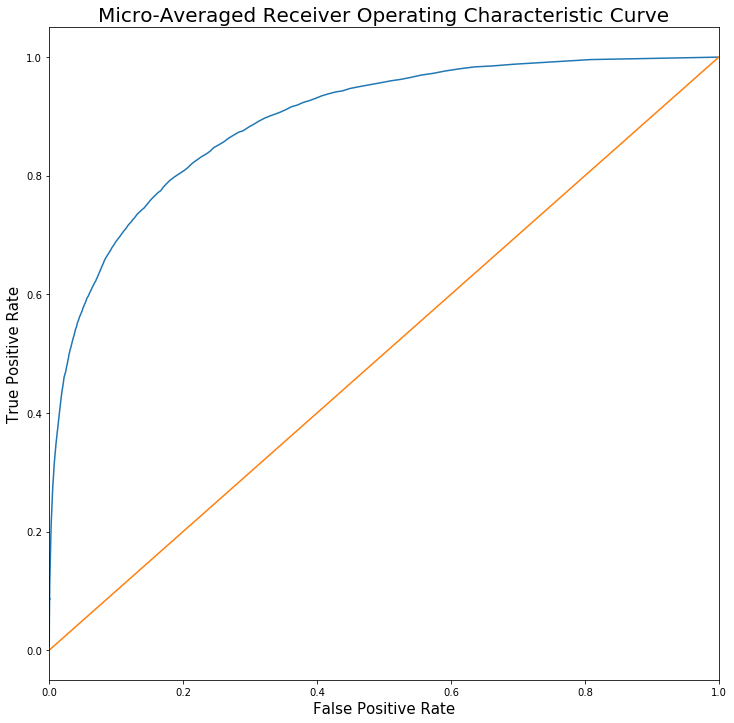

In [43]:
## Plot Micor-Average Receiver Operating Characteristic Curve
ax = TPR_and_FPR.sort_values('FPR').plot(
    x='FPR',
    y='TPR',
    figsize = (12,12),
    legend = False)

ax.set_xlabel('False Positive Rate',fontsize = 15)
ax.set_ylabel('True Positive Rate',fontsize = 15)
ax.set_title("Micro-Averaged Receiver Operating Characteristic Curve",fontsize=20)
ax.plot([0,1],[0,1])

In [44]:
spark.stop()